# _*Portfolio Optimization*_ 


## Introduction

This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) or the Quantum Approximate Optimization Algorithm (QAOA) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
<a href="https://arxiv.org/abs/1907.04769">Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.</a>

## Table of Contents

1. [Import the libraries](#import)
2. [Define the problem](#prob)
3. [Solution](#solution)

<a id = "import"></a>
## Import the libraries

Qiskit is an open source SDK for working with quantum computers at the level of pulses, circuits and application modules.

The Qiskit Optimization package covers the whole range from high-level modeling of optimization problems, with automatic conversion of problems to different required representations, to a suite of easy-to-use quantum optimization algorithms that are ready to run on classical simulators, as well as on real quantum systems.

### Installation
We encourage installing Qiskit via the pip tool (a python package manager).

`pip` will handle all dependencies automatically and you will always install the latest (and well-tested) version.

If you want to work on the very latest work-in-progress versions, learn more about Qiskit, or if you want to contribute to Qiskit Optimization visit `qiskit.org` for more information

In [1]:
pip install -q qiskit

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q qiskit_optimization

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q qiskit_finance

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


In [4]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime

### Setup token to run the experiment on a real device


<div class="alert alert-block alert-info">
    Note: This step is optional.
</div>
If you would like to run the experiment on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.

<a id = "prob"></a>
## Define problem instance

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the portfolio problem. We use a random portfolio problem for this notebook. It is straight-forward to extend this to using real financial data as illustrated here:<br>
[Loading and Processing Stock-Market Time-Series Data](11_time_series.ipynb)

In [5]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(2016,1,1),
                 end=datetime.datetime(2016,1,30),
                 seed=seed)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

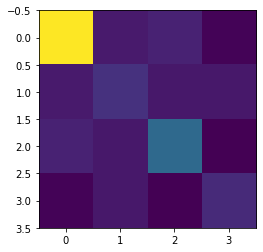

In [6]:
# plot sigma
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [7]:
q = 0.5                   # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets      # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.015284386652 x_0 + 0.000780952145 x_1 - 0.000517920547 x_2
      - 0.000870005837 x_3 + [ 0.002541388592 x_0^2 + 0.000146804433 x_0*x_1
      + 0.000257201062 x_0*x_2 - 0.000199722426 x_0*x_3 + 0.000258486713 x_1^2
      + 0.000106085519 x_1*x_2 + 0.000088963242 x_1*x_3 + 0.000791504681 x_2^2
      - 0.000247774763 x_2*x_3 + 0.000197892585 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End

We define some utility methods to print the results in a nice format.

In [8]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

<a id = "solution"></a>
## NumPyMinimumEigensolver (as a classical reference)
Lets solve the problem. First classically...

We can now use the Operator we built above without regard to the specifics of how it was created. We set the algorithm for the NumPyMinimumEigensolver so we can have a classical reference. The problem is set for 'ising'. Backend is not required since this is computed classically not using quantum computation. The result is returned as a dictionary.

In [9]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		1.0000
 [1 1 1 1]	4.0656		0.0000
 [0 1 1 1]	1.0199		0.0000
 [1 0 1 1]	1.0049		0.0000
 [0 0 1 1]	-0.0010		0.0000
 [1 1 0 1]	1.0060		0.0000
 [0 1 0 1]	0.0002		0.0000
 [0 0 0 1]	1.0191		0.0000
 [1 1 1 0]	1.0069		0.0000
 [0 1 1 0]	0.0008		0.0000
 [1 0 1 0]	-0.0140		0.0000
 [0 0 1 0]	1.0197		0.0000
 [1 1 0 0]	-0.0130		0.0000
 [0 1 0 0]	1.0208		0.0000
 [1 0 0 0]	1.0059		0.0000
 [0 0 0 0]	4.0795		0.0000


## Solution using VQE
We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

Note: You can switch to different backends by providing the name of backend.

In [10]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	0.0002		0.5235
 [1 1 0 0]	-0.0130		0.3667
 [0 1 1 0]	0.0008		0.1041
 [1 0 0 1]	-0.0149		0.0053
 [0 0 1 1]	-0.0010		0.0002
 [1 1 1 0]	1.0069		0.0001
 [0 1 1 1]	1.0199		0.0001
 [1 0 1 1]	1.0049		0.0000
 [0 0 1 0]	1.0197		0.0000
 [1 1 0 1]	1.0060		0.0000
 [0 1 0 0]	1.0208		0.0000
 [0 0 0 0]	4.0795		0.0000
 [1 0 1 0]	-0.0140		0.0000
 [1 0 0 0]	1.0059		0.0000
 [1 1 1 1]	4.0656		0.0000
 [0 0 0 1]	1.0191		0.0000


### Solution using QAOA

We also show here a result using the Quantum Approximate Optimization Algorithm (QAOA). This is another variational algorithm and it uses an internal variational form that is created based on the problem.

In [11]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.1742
 [1 0 1 0]	-0.0140		0.1736
 [1 1 0 0]	-0.0130		0.1724
 [0 0 1 1]	-0.0010		0.1605
 [0 1 0 1]	0.0002		0.1595
 [0 1 1 0]	0.0008		0.1587
 [1 0 1 1]	1.0049		0.0002
 [0 1 0 0]	1.0208		0.0002
 [1 1 0 1]	1.0060		0.0001
 [0 0 1 0]	1.0197		0.0001
 [0 0 0 1]	1.0191		0.0001
 [1 1 1 0]	1.0069		0.0001
 [1 0 0 0]	1.0059		0.0001
 [0 1 1 1]	1.0199		0.0001
 [1 1 1 1]	4.0656		0.0000
 [0 0 0 0]	4.0795		0.0000


In [12]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

# <hr>
Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.